In [1343]:
import numpy as np
import pandas as pd

In [1344]:
# Save both dataframes

df_words_similarities = pd.read_csv('words_similarities.csv', index_col=0)
df_words_similarities[df_words_similarities < 0] = 0
df_words_similarities[df_words_similarities > 1] = 1


df_locations_similarities = pd.read_csv('locations_similarities.csv', index_col=0)


Load the states of the environment

In [1345]:
df_env_states = pd.read_csv('environment_states.csv', index_col=0)
df_env_novel_states = pd.read_csv('environment_novel_states.csv', index_col=0)
# Select 5 rows
df_env_novel_states = df_env_novel_states.sample(3)

Tune the similarity matrix to fit to the novel episode semantics

In [1346]:
df_words_similarities_tuned = df_words_similarities.copy()

for word in df_env_novel_states['word'].unique():
    sim = 1
    # Add 1 and divide by 2 to the column of the word
    df_words_similarities_tuned[word] = sim
    # Add 1 and divide by 2 to the index of the word
    df_words_similarities_tuned.loc[word] = sim


df_words_similarities_tuned = df_words_similarities_tuned ** 5

In [1347]:
from sklearn.manifold import MDS
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=0)
semantic_mds = mds.fit_transform(df_words_similarities_tuned).reshape(-1)

# Scale time to be between 0 and 1
df_env_states['time'] = df_env_states['time'] / df_env_states['time'].max()

# Scale semantic_mds to be between 0 and 1
# semantic_mds = (semantic_mds - semantic_mds.min()) / (semantic_mds.max() - semantic_mds.min())
df_semantic_mds = pd.DataFrame({'semantic_mds': semantic_mds}, index=df_words_similarities_tuned.index)

# mutate locations column to have integers
locations = df_env_states['location'].unique()
locations_dict = {location: i for i, location in enumerate(locations)}
inv_locations_dict = {i: location for i, location in enumerate(locations)}

df_env_states['location'] = df_env_states['location'].map(locations_dict)

In [1348]:
from environments_episodic import EpisodicGraph
from environments import RoomWorld
from generators import Generator
from propagators import Propagator
from simulators_episodic import EpisodicSimulator 

# Create the environment
k = 1  # Inter-episode connectivity. Domain: [0, 1]. 1, sample across episodes. 0, sample within episodes
m = 2 # Action Similarity weight. Domain: [0, inf]. 0, no action dependence.
n = 1  # Time diference weight. Domain: [0, inf]. 0, no time dependence.

n_step = 25
n_samp = 50
init_state = 0

env = EpisodicGraph(df_env_states, df_words_similarities_tuned, df_semantic_mds, k=k, m=m, n=n)
# env = RoomWorld()

# Create the generator
generator = Generator(env)

# Create the propagator
propagator = Propagator(generator, alpha=1., tau=5)

# Create the simulator
simulator = EpisodicSimulator(propagator, init_state)

# Simulate
simulator.sample_sequences(n_step=n_step, n_samp=n_samp)

seqs_1 = simulator.state_seqs


GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is not symmetric.
GENERATOR: Q is a generator with shape (120, 120) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 1


In [1349]:
def episodic_rl_algorithm(df_env_states, df_env_novel_states, max_seqs = 40, n_samp=50, thresh=0.4):
    seqs = np.zeros((n_samp, max_seqs), dtype=int)

    for i in range(n_samp):
        seqs_i = []

        # Group df_env_states by location
        df_env_states_2 = df_env_states.copy()
        
        # Add a id column to df_env_states_2
        df_env_states_2['id'] = np.arange(len(df_env_states_2))
        df_env_states_by_location = df_env_states_2.groupby('location')

        random_group_id = 0
        while len(seqs_i) < max_seqs and random_group_id < df_env_states['location'].max():
            # Get random group
            random_group = df_env_states_by_location.get_group(random_group_id)
            random_group_id += 1
            
            # Get random_row
            random_row = random_group.sample(n=1)
            seqs_i.append(random_row['id'].values[0])

            # Eval each word from df_env_novel_states with the random_row
            sim_max = 0
            for word in df_env_novel_states['word'].unique():
                # Get the similarity between the word and the random_row
                sim = df_words_similarities.loc[word, random_row['word'].values[0]]
                if sim > sim_max:
                    sim_max = sim
            
            if sim_max > thresh:
                random_rows = random_group.sample(frac=0.9, replace=False)
                [seqs_i.append(i) for i in random_rows['id'].values]

        seqs[i] = np.array(seqs_i)[:max_seqs]
    return seqs

seqs_2 = episodic_rl_algorithm(df_env_states, df_env_novel_states, max_seqs=n_step, thresh=0.5)

In [1350]:
def create_df_sequences(seqs):
    df_sequences = pd.DataFrame()
    for i in range(seqs.shape[0]):
        df_i = df_env_states.iloc[seqs[i, :]]
        # Append a column with the sequence number
        df_i["seq"] = i
        df_sequences = pd.concat([df_sequences, df_i], ignore_index=True)
    return df_sequences

In [1351]:
# Create a pandas dataframe with the states sequence
df_sequences = pd.DataFrame()
df_sequences_i = create_df_sequences(seqs_1)
df_sequences_i["m"] = m
df_sequences_i["n"] = n
df_sequences_i["model"] = "Episodic Inference"

df_sequences = df_sequences.append(df_sequences_i, ignore_index=True)

df_sequences_i = create_df_sequences(seqs_2)
df_sequences_i["m"] = m
df_sequences_i["n"] = n
df_sequences_i["model"] = "Episodic RL"

df_sequences = df_sequences.append(df_sequences_i, ignore_index=True)

df_sequences = df_sequences.groupby('model')

In [1352]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_environment(df_env_states, words_sorted, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 5))

    colors = ["r", "b"] * (len(df_env_states["location"].unique()) // 2 + 1)

    from matplotlib.patches import Rectangle

    rectangle_height = len(df_env_states["word"].unique())
    i_prev = 0
    for c, i in zip(colors, [10] * len(df_env_states["location"].unique())):
        rect = Rectangle((i_prev - 0.5, - 0.5), i, rectangle_height + 0.5, linewidth=1, facecolor=c, alpha=0.05)
        ax.add_patch(rect)
        # Plot locations name at the center of the rectangle
        label = inv_locations_dict[df_env_states.loc[i_prev]["location"]]
        ax.text(i_prev + i / 2, rectangle_height - 3, label, fontsize=9, ha='center', alpha = 0.5, color=c)

        i_prev += i

    # set limits
    ax.set_xlim(-1, len(df_env_states))
    ax.set_ylim(len(df_env_states["word"].unique()) - 0.5, -0.5)

    for i, row in df_env_states.iterrows():
        ax.scatter(row['time'] * (len(df_env_states) - 1), words_sorted[row['word']], color='k', s=50, alpha=0.2)

    # Shuffle y axis
    ax.set_yticks(np.arange(len(words_sorted.keys())))
    # Set words_sampled in reverse order
    ax.set_yticklabels(words_sorted.keys())

    return ax


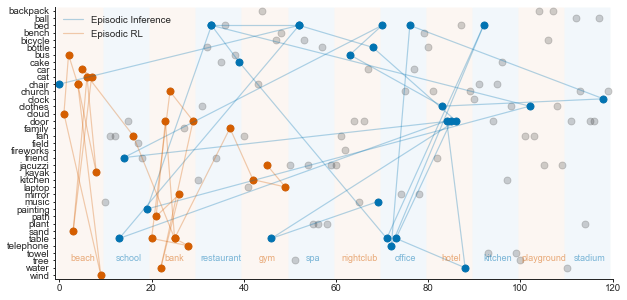

In [1353]:
fig, ax = plt.subplots(figsize=(10, 5))

# Extract the unique words from the sampled df
words_sorted = df_env_states['word'].unique()
# Order it alphabetically
words_sorted.sort()
# Create a dict with the index of each word
words_sorted = {word: i for i, word in enumerate(words_sorted)}

plot_environment(df_env_states, words_sorted, ax=ax)

# plot the df_sequences

for c, (name, df_sequences_i) in zip(["b", "r"], df_sequences):
    # reset index
    df_sequences_i = df_sequences_i.reset_index(drop=True)
    df_sequences_i = df_sequences_i.groupby('seq')

    # Extract fir
    for seq_i, df_sequences_seq_i in df_sequences_i:
        for i, row in df_sequences_seq_i.iterrows():
            ax.scatter(row['time'] * (len(df_env_states) - 1), words_sorted[row['word']], color=c, s=50, alpha=1)
            # add lines conecting the points
            if i > 0:
                if i == 1:
                    ax.plot([df_sequences_seq_i.iloc[i - 1]['time'] * (len(df_env_states) - 1), row['time'] * (len(df_env_states) - 1)],
                            [words_sorted[df_sequences_seq_i.iloc[i - 1]['word']], words_sorted[row['word']]], color=c, alpha=0.3, label=name)
                else:
                
                    ax.plot([df_sequences_seq_i.iloc[i - 1]['time'] * (len(df_env_states) - 1), row['time'] * (len(df_env_states) - 1)],
                            [words_sorted[df_sequences_seq_i.iloc[i - 1]['word']], words_sorted[row['word']]], color=c, alpha=0.3)
        break
ax.legend()
plt.show()

In [1354]:
# compute the evaluation

def compute_evaluation(df_sequences, df_env_novel_states):
    # Group_by model
    df_sequences_by_model = df_sequences

    # To each unique word of the model apply the semantic similarity to the novel words and get the mean
    df_sequences_by_model_sim = df_sequences_by_model.apply(lambda z: z.groupby('seq')
                                                            .apply(lambda x: x['word']
                                                                   .apply(lambda y: df_words_similarities.loc[y, df_env_novel_states['word'].unique()]).mean())) 

    
    # Average columns
    df_sequences_by_model_sim = df_sequences_by_model_sim.apply(lambda x: x.mean(), axis=1)
    df_sequences_by_model_sim = df_sequences_by_model_sim.reset_index()
    df_sequences_by_model_sim.columns = ["model", "seq", "similarity"]
    
    return df_sequences_by_model_sim

df_eval = compute_evaluation(df_sequences, df_env_novel_states)


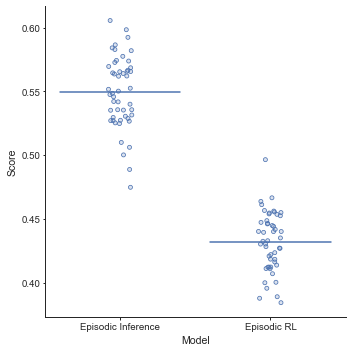

In [1355]:
import seaborn.objects as so

fig, ax = plt.subplots(figsize=(5, 5))
p = (
    so.Plot(df_eval, x="model", y="similarity")
    .add(so.Dash(color="b"), so.Agg())
    .add(so.Dots(color="b"), so.Jitter())
    .label(
        x="Model",
        y="Score",
    )
    .layout(
        engine="tight",
    )
    .on(ax)
    .plot()
)


In [1356]:
df_env_states_numpy = df_env_states.copy()

df_env_states_numpy["word"] = df_env_states_numpy["word"].apply(lambda x: df_semantic_mds.loc[x][0])

df_env_states_numpy = df_env_states_numpy.to_numpy().astype(np.float32)

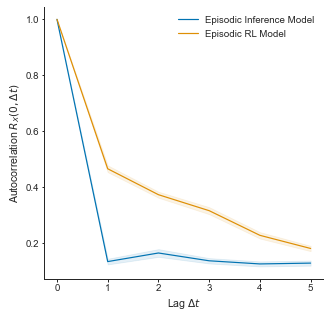

In [1359]:
from autocorrelation import estimate_episodic_acf_v2

samps_state = df_env_states_numpy[seqs_1]
acf_mean, acf_sem = estimate_episodic_acf_v2(samps_state, axis=(0, 1))

samps_state = df_env_states_numpy[seqs_2]
dummy_acf_mean, dummy_acf_sem = estimate_episodic_acf_v2(samps_state, axis=(0, 1))

lags = np.arange(0, 6)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# plot mean
ax.plot(lags, acf_mean[lags], label="Episodic Inference Model", color="C0")
ax.fill_between(lags, acf_mean[lags] - acf_sem[lags], acf_mean[lags] + acf_sem[lags], alpha=0.1, color="C0")

ax.plot(lags, dummy_acf_mean[lags], label="Episodic RL Model", color="C1")
ax.fill_between(lags, dummy_acf_mean[lags] - dummy_acf_sem[lags], dummy_acf_mean[lags] + dummy_acf_sem[lags], alpha=0.1, color="C1")

# add legend
ax.legend()

# add labels
ax.set_xlabel("Lag $\Delta t$")
ax.set_ylabel("Autocorrelation $R_X(0, \Delta t)$")

# set y limits
# ax.set_ylim(-0.1, 1.1)

plt.show()